# Introduction

This code belongs to authors of paper RWF 2000.
Check the link below for more information.


Src: https://github.com/mchengny/RWF2000-Video-Database-for-Violence-Detection

Image from original repository:

![RWF2000](https://github.com/mchengny/RWF2000-Video-Database-for-Violence-Detection/raw/master/Images/blocked.gif)

To cite:
>"Ming Cheng, Kunjing Cai, and Ming Li. "RWF-2000: An Open Large Scale Video Database for Violence Detection." arXiv preprint arXiv:1911.05913 (2019)."


# Preprocessing

In [1]:
# Transform Video to .npy Format
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from pathlib import Path
from random import shuffle

In [2]:
def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img,(224,224,1)))

    flows = []
    for i in range(0,len(video)-1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i+1], None, 0.5, 3, 15, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0],None,0,255,cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1],None,0,255,cv2.NORM_MINMAX)
        # Add into list 
        flows.append(flow)
        
    # Padding the last frame as empty array
    flows.append(np.zeros((224,224,2)))
      
    return np.array(flows, dtype=np.float32)

In [3]:
def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows 
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)   
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()
            
    # Get the optical flow of video
    flows = getOpticalFlow(frames)
    
    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows
    
    return result

In [4]:
def Save2Npy(videos, save_dir):
    """Transfer all the videos and save them into specified directory
    Args:
        videos: list of target videos with pathlib Path.
        save_dir: destination folder of output .npy files
    """
    
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    
    for path in tqdm(videos):
        # Split video name
        name = path.stem
        # Get dest 
        save_path = Path(save_dir) / (name + '.npy')
        # os.path.join(save_dir, name + '.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=path.as_posix(), resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path.as_posix(), data)
    
    return None

In [5]:
source_path = '../input/violence/Peliculas'
target_path = './'

each_video = './train/fights'
each_video = './train/noFights'

fight_videos =list(Path('../input/violence/Peliculas/fights').rglob('*.avi'))
nofight_videos = list(Path('../input/violence/Peliculas/noFights').rglob('*.mpg'))

print(len(fight_videos))
print(len(nofight_videos))

n_fights = len(fight_videos)
train_size = int(0.8 * n_fights)

train_fights = fight_videos[:train_size]
train_nofights = nofight_videos[:train_size]
val_fights = fight_videos[train_size:]
val_nofights = nofight_videos[train_size:]

Save2Npy(train_fights, target_path+'/train/fight')
Save2Npy(train_nofights, target_path+'/train/nofight')
Save2Npy(val_fights, target_path+'/val/fights')
Save2Npy(val_nofights, target_path+'/val/nofights')

  0%|          | 0/80 [00:00<?, ?it/s]

100
101


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Build Data Loader

> Based on this article: 
> https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

Only rewrite these functions:

- def \__len__(self):
- def \__getitem__(self, index):
- def on_epoch_end(self):

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Multiply, Input, Lambda,
                                     BatchNormalization)

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda

In [8]:
from tensorflow.keras.utils import Sequence, to_categorical

class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args: 
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    Note:
        If you want to load file with other data format, please fix the method of "load_data" as you want
    """
    def __init__(self, directory, batch_size=1, shuffle=True, data_augmentation=True):
        # Initialize the params
        self.batch_size = batch_size
        self.directory = directory
        self.shuffle = shuffle
        self.data_aug = data_augmentation
        # Load all the save_path of files, and create a dictionary that save the pair of "data:label"
        self.X_path, self.Y_dict = self.search_data() 
        # Print basic statistics information
        self.print_stats()
        return None
    
    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """
        Get the data of each batch
        
        """
        # get the indexs of each batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # using batch_indexs to get path of current batch
        batch_path = [self.X_path[k] for k in batch_indexs]
        # get batch data
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        """
        shuffle the data at each end of epoch
        
        """
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def search_data(self):
        """
        1 - Lists subfolders.
        2 - takes all the names of npy files in th paths
        3 - make the one-hot encoded labels.
        """
        X_path = []
        Y_dict = {}
        # list all kinds of sub-folders
        self.dirs = sorted(os.listdir(self.directory))
        one_hots = to_categorical(range(len(self.dirs)))
        for i,folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory,folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path,file)
                # append the each file path, and keep its label  
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict
    
    def print_stats(self):
        """
        calculate basic information
        
        """
        self.n_files = len(self.X_path)
        self.n_classes = len(self.dirs)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        # Output states
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(self.dirs):
            print('%10s : '%(label),i)
        return None
    
    def data_generation(self, batch_path):
        """"
        load data into memory, you can change the np.load to any method you want
        
        """
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]
        # transfer the data format and take one-hot coding for labels
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y
    
    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std
    
    def load_data(self, path):
        # load the processed .npy files which have 5 channels (1-3 for RGB, 4-5 for optical flows)
        data = np.load(path, mmap_mode='r')
        data = np.float32(data)
        # sampling 64 frames uniformly from the entire video
        data = self.uniform_sampling(video=data, target_frames=64)
        # whether to utilize the data augmentation
        if  self.data_aug:
            data[...,:3] = self.color_jitter(data[...,:3])
            data = self.random_flip(data, prob=0.5)
        # normalize rgb images and optical flows, respectively
        data[...,:3] = self.normalize(data[...,:3])
        data[...,3:] = self.normalize(data[...,3:])
        return data
    
    def uniform_sampling(self, video, target_frames=64):
        """
        1 - Count the number of frames.
        2 - calculate the interval = num_frames/target_frames
        3 - Take frames from video after skipping interval frames in between.
        
        """
        # get total frames of input video and calculate sampling interval 
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and 
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])     
        # calculate numer of padded frames and fix it 
        num_pad = target_frames - len(sampled_video)
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try: 
                    padding.append(video[i])
                except:
                    padding.append(video[0])
            sampled_video += padding     
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)
    
    def random_flip(self, video, prob):
        """
        # Augmentation
        flips all the video frames
        """
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video
    
    def random_clip(self, video, target_frames=64):
        """
        # Augmentation
        randomly clips some part of video.
        """
        start_point = np.random.randint(len(video)-target_frames)
        return video[start_point:start_point+target_frames]
    
    def dynamic_crop(self, video):
        """
        # Augmentation
        
        """
        # extract layer of optical flow from video
        opt_flows = video[...,3]
        # sum of optical flow magnitude of individual frame
        magnitude = np.sum(opt_flows, axis=0)
        # filter slight noise by threshold 
        thresh = np.mean(magnitude)
        magnitude[magnitude<thresh] = 0
        # calculate center of gravity of magnitude map and adding 0.001 to avoid empty value
        x_pdf = np.sum(magnitude, axis=1) + 0.001
        y_pdf = np.sum(magnitude, axis=0) + 0.001
        # normalize PDF of x and y so that the sum of probs = 1
        x_pdf /= np.sum(x_pdf)
        y_pdf /= np.sum(y_pdf)
        # randomly choose some candidates for x and y 
        x_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=x_pdf)
        y_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=y_pdf)
        # get the mean of x and y coordinates for better robustness
        x = int(np.mean(x_points))
        y = int(np.mean(y_points))
        # avoid to beyond boundaries of array
        x = max(56,min(x,167))
        y = max(56,min(y,167))
        # get cropped video 
        return video[:,x-56:x+56,y-56:y+56,:]  
    
    def color_jitter(self,video):
        """
        # Augmentation
        
        """
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video

In [9]:

# extract the rgb images 
def get_rgb(input_x):
    rgb = input_x[...,:3]
    return rgb

# extract the optical flows
def get_opt(input_x):
    opt= input_x[...,3:5]
    return opt

# Build Model

# The model Architecture:

The network consists of 2 parallel nets:

- RGB input
- Optical flow input

the output of these networks are then multiplied to keep the RGB features which there is movement in sequence of frames. (take a look at figure 5 - cropping strategy)

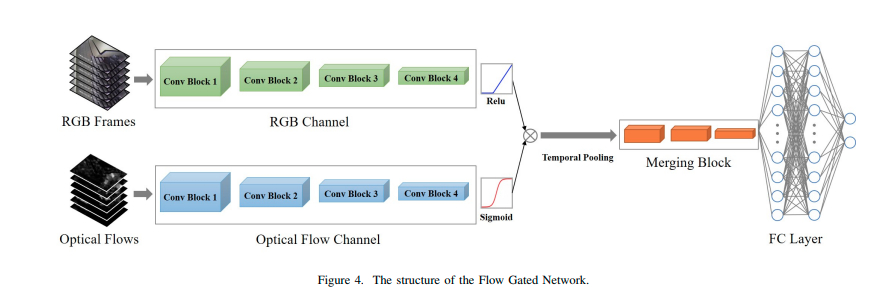


# Cropping strategy:

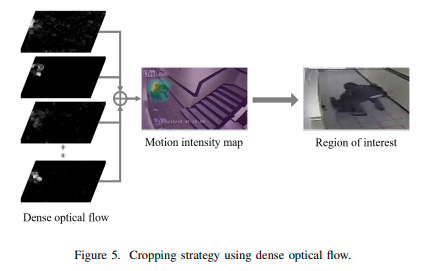


In [10]:
inputs = Input(shape=(64,224,224,5))

rgb = Lambda(get_rgb,output_shape=None)(inputs)
opt = Lambda(get_opt,output_shape=None)(inputs)

##################################################### RGB channel
rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

##################################################### Optical Flow channel
opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)


##################################################### Fusion and Pooling
x = Multiply()([rgb,opt])
x = MaxPooling3D(pool_size=(8,1,1))(x)

##################################################### Merging Block
x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,3,3))(x)

##################################################### FC Layers
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# Build the model
pred = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=pred)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 224, 224 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 224, 224, 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 224, 224, 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 224, 224, 448         lambda[0][0]                     
______________________________________________________________________________________________

# Model Compiling

In [11]:
from keras.optimizers import Adam, SGD

sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Set Callbacks
- Learning Rate Scheduler

In [12]:
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint, CSVLogger
import keras

def scheduler(epoch):
    if epoch % 8 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.85)
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

class MyCbk(keras.callbacks.Callback):

    def __init__(self, model):
         self.model_to_save = model

    def on_epoch_end(self, epoch, logs=None):
        self.model_to_save.save('Logs/model_at_epoch_%d.h5' % (epoch+1))

check_point = MyCbk(model)


filename = 'Logs/ours_log.csv'

csv_logger = CSVLogger(filename, separator=',', append=True)

callbacks_list = [check_point, csv_logger, reduce_lr]


In [13]:
!mkdir Logs
!touch Logs/outs_log.csv

In [14]:
num_epochs  = 40
num_workers = 6
batch_size  = 3

train_generator = DataGenerator(directory='./train', 
                                batch_size=batch_size, 
                                data_augmentation=True)

val_generator = DataGenerator(directory='./val',
                              batch_size=batch_size, 
                              data_augmentation=False)

hist = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1,
    epochs=num_epochs,
    workers=num_workers,
    max_queue_size=4,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

Found 160 files belonging to 2 classes.
     fight :  0
   nofight :  1
Found 41 files belonging to 2 classes.
    fights :  0
  nofights :  1
Epoch 1/40
54/54 [==============================] - 132s 2s/step - loss: 0.7717 - accuracy: 0.5912 - val_loss: 0.1710 - val_accuracy: 0.9756
Epoch 2/40
54/54 [==============================] - 114s 2s/step - loss: 1.1706 - accuracy: 0.5922 - val_loss: 0.6932 - val_accuracy: 0.4878
Epoch 3/40
54/54 [==============================] - 114s 2s/step - loss: 0.6986 - accuracy: 0.4234 - val_loss: 0.6937 - val_accuracy: 0.4878
Epoch 4/40
54/54 [==============================] - 113s 2s/step - loss: 0.6963 - accuracy: 0.5013 - val_loss: 0.6929 - val_accuracy: 0.5122
Epoch 5/40
54/54 [==============================] - 115s 2s/step - loss: 0.6976 - accuracy: 0.5103 - val_loss: 0.6958 - val_accuracy: 0.4878
Epoch 6/40
54/54 [==============================] - 114s 2s/step - loss: 0.6924 - accuracy: 0.5462 - val_loss: 0.6992 - val_accuracy: 0.4878
Epoch 7/40
